# Introduction

This notebook is used to retrieve data from USGS using `dataRetrieval` R package. For tutorial, see [slides](https://owi.usgs.gov/R/dataRetrieval.html) and [documentation](https://pubs.usgs.gov/tm/04/a10/pdf/tm4A10_appendix_1.pdf). The source code is located at [Github](https://github.com/IRkernel/IRkernel).

## Install packages

Install the `dataRetrieval` R package

In [1]:
ipak <- function(pkg){
    new.pkg <- pkg[!(pkg %in% installed.packages()[, "Package"])]
    if (length(new.pkg)) 
        install.packages(new.pkg, dependencies = TRUE)
    sapply(pkg, require, character.only = TRUE)
}

packages <- c('padr', 'dplyr', 'dataRetrieval', 'ggplot2', 'data.table', 'rgdal', 'leaflet', 'htmlwidgets')
ipak(packages)

Loading required package: padr

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: dataRetrieval

Loading required package: ggplot2

Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


Loading required package: rgdal

Loading required package: sp

rgdal: version: 1.5-12, (SVN revision 1018)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.0.4, released 2020/01/28
Path to GDAL shared files: /opt/anaconda3/envs/main/share/gdal
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 7.0.0, March 1st, 2020, [PJ_VERSION: 700]
Path to PROJ shared files: /Users/shua784/Library/Application Support/proj:/opt/anaconda3/envs/main/shar

padr         dplyr dataRetrieval       ggplot2    data.table 
         TRUE          TRUE          TRUE          TRUE          TRUE 
        rgdal       leaflet   htmlwidgets 
         TRUE          TRUE          TRUE

In [2]:
# out_dir = "/global/project/projectdirs/m1800/pin/Reach_scale_model/data/well_data/GW_chemistry/"
out_dir = "./results/"
fig_dir = "./figures/"
gis_file = "./data/"

## Custom functions

**fill time gap with NA**

Note: 
1. The method below is from this [post](https://stackoverflow.com/questions/51003167/inserting-nas-during-time-gaps). This method is useful when you have irregular missing gaps in observations (eg. manual measurement of DOC concentration in the field), and do not want to connect the points when plotting.
2. If observation is more continuous and is missing some time period (e.g. automated water level), use `dplyr` or `padr` (see this [post](https://stackoverflow.com/questions/16787038/insert-rows-for-missing-dates-times))

In [3]:
fillGapNA <- function(df, t_day){
    ## inputs: df-- the data.frame; timeStamp-- datetime column variable; t_day-- target time gap
    ## outputs: return df in data.table format with filled NA in the specified gap
    
    # set data.table
    setDT(df)
#     col = get(timeStamp)
    # find gap larger than t_gap min
    t_gap = t_day*24*60 # in minutes
    df[, gap := c(diff(timeStamp) > t_gap, F)]

    # insert NA in between the gap
    df = df[, if(gap) rbind(.SD, .(timeStamp = timeStamp + t_gap*60/2), fill = T)
     else .SD
    , by = 1:nrow(df)
    ][, -'gap']
    
    return(df)
}

**add cumstom legend**

In [4]:
# colors <- c("red", "white", "blue", "white", "blue", "red")
#         labels <- c("filled_square", "empty_square", "big_square", "empty_circle", "filled_circle", "big_circle")
#         sizes <- c(10, 20, 30, 10, 20, 30)
#         shapes <- c("square", "square", "square", "circle", "circle", "circle")
#         borders <- c("red", "blue", "black", "blue", "blue", "black")

addLegendCustom <- function(map, colors, labels, sizes, shapes, borders, opacity = 0.8){

            make_shapes <- function(colors, sizes, borders, shapes) {
                shapes <- gsub("circle", "50%", shapes)
                shapes <- gsub("square", "0%", shapes)
                paste0(colors, "; width:", sizes, "px; height:", sizes, "px; border:3px solid ", borders, "; border-radius:", shapes)
            }
            make_labels <- function(sizes, labels) {
                paste0("<div style='display: inline-block;height: ", 
                       sizes, "px;margin-top: 4px;line-height: ", 
                       sizes, "px;'>", labels, "</div>")
            }

            legend_colors <- make_shapes(colors, sizes, borders, shapes)
            legend_labels <- make_labels(sizes, labels)

            return(addLegend(map, colors = legend_colors, 
                             labels = legend_labels, opacity = opacity, title = "Site Type"))
        }

## parameter code

USGS use various codes for basic retrievals:

- site id
- parameter code ([full list](https://help.waterdata.usgs.gov/code/parameter_cd_query?fmt=rdb&inline=true&group_cd=%))

    - common codes
    
|code|name|$unit$|
|----|----|---|
|00010|Temperature, water|$deg C$|
|00060|discharge, |$ft^3/s$|
|00065|gage height, |$ft$|
|00095|Specific conductance, water, unfiltered|$uS/cm @25C$|
|00300| Dissolved oxygen|$mg/L$|
|00301|Diss oxygen| %saturtn
|00400| pH
|00618|nitrate, filtered (dissovled), water, |$mg/L$|
|00620|nitrate, unfiltered (total), water, |$mg/L$|
|00681|DOC|$mg/L$|
|63680| Turbidity | Form Neph
|72019|depth to water level| ft
|99133| NO3+NO2 water,insitu|$mg/L$

- statistic code ([full list](https://help.waterdata.usgs.gov/code/stat_cd_nm_query?stat_nm_cd=%25&fmt=html))

    - common codes
    
code|name
:---:|:---:
00001|maximum
00002|minimum
00003|mean

As an alternative, you can search for specific parameters or even download the complete parameter code names.

In [ ]:
#find all the parameter codes
parameterCdFile <- parameterCdFile
names(parameterCdFile)
write.csv(parameterCdFile,'./data/parameterCdFile.csv')

In [ ]:
#find para codes with "nitrate"
NO3Cds <- parameterCdFile[grep("nitrate",
                                parameterCdFile$parameter_nm,
                                ignore.case=TRUE),]

## function names

Common query functions:

See examples of [readNWIS](https://owi.usgs.gov/R/training-curriculum/usgs-packages/dataRetrieval-readNWIS/) and [readWQP](https://owi.usgs.gov/R/training-curriculum/usgs-packages/dataRetrieval-readWQP/) on how to use each function.

Function|Description|arguments|example
:---:|:---:|:---:|:---:
whatNWISdata|discover what data is available at a site|siteNumbers,service, statCd|whatNWISdata(siteNumbers,service="dv", statCd="00003")
readNWISdata|user specified query|must include `service={'iv','uv','dv','gwlevels','site','qw','measurement','stat'}`|box region selection, stateCd
readNWISdv| query *daily* data (e.g. daily freq)|siteNumbers, parameterCd, startDate, endDate, statCd|river gage, discharge, temperature
readNWISqw| quality data from water samples collected at the streamgage or other monitoring site (**different from `dv` autologger data**)|siteNumbers, parameterCd, startDate, endDate, expanded, reshape, tz|nitrate
readNWISuv|query *unit* data (e.g. 15 min freq., real-time)|siteNumbers, parameterCd, startDate, endDate, tz|river gage, discharge
readNWISgwl|query *groundwater level*|	siteNumbers, startDate, endDate, convertType, tz|
readNWISmeas| discrete measurements of discharge that are made for the purpose of developing or revising the rating curve|siteNumbers, startDate, endDate, tz, expanded, convertType|
readNWISpCode|parameter code info|readNWISpCode(parameterCd)
readNWISsite| site info| readNWISsite(siteNumbers)
readNWISuse|data from USGS nation water use program|	stateCd, countyCd, years, categories, convertType, transform|
renameNWISColumns|rename column names from NWIS retrievals|
readWQPqw|retrieve water quality data from USGS and EPA ([link](https://www.waterqualitydata.us/portal/))| siteNumbers, parameterCd, startDate, endDate| full site name is required, e.g., USGS-01234567, must know siteNumber and paraCd
readWQPdata|general function for query data|readWQPdata(statecode="WI",characteristicName="Phosphorus")| list of [characteristic names](https://www.waterqualitydata.us/public_srsnames/) and [acceptable arguments](https://www.waterqualitydata.us/webservices_documentation/#WQPWebServicesGuide-Submitting)
whatWQPsites|return sites info|whatWQPsites(statecode="WI",characteristicName="Phosphorus")| not as robust as `readNWISsite`



To access the help file for each function name, do the following `?FUNCTION`

In [286]:
?readNWISdata

## output columns

Common output Dataframe column names:

name|description|example
---|---|---
site_no|site identification number|01463500
station_nm|site name|Delaware River at Trenton NJ
site_tp_cd|site type|ST, GW
dec_lat_va|decimal latitude
dec_long_va|decimal longitude
coord_ary_cd|latitude-longitude accuracy
alt_va|altutude of gage/land surface
alt_datum_cd|altitude datum
data_type_cd|dv, iv, gw, qw
parm_cd|parameter code|00010
stat_cd|statistic code|00001
begin_date|
end_date|
cout_nu|cout number

# query data based on known site id

**inputs**

In [292]:
siteNumber = "01472150"
# parameterCd = "00600"
pCode = c("00060", "00065")
startDate <- as.Date("1980-01-01")
# endDate = as.Date('2019-01-01')
endDate = Sys.Date()

statCd <- "00003" #00001	Maximum; 00002	Minimum ; 00003	Mean; 00008	Median

**site information**

In [ ]:
siteInfo <- readNWISsite(siteNumber)

names(siteInfo)

siteInfo$alt_va

**available data**

In [271]:
avail_data = whatNWISdata(siteNumber = siteNumber)

In [272]:
parameter_cd = avail_data$parm_cd

readNWISpCode(parameter_cd)

Warning message in readNWISpCode(parameter_cd):
“The following pCodes seem mistyped, and no information was returned: ”

,parameter_cd,parameter_group_nm,parameter_nm,casrn,srsname,parameter_units
10,00028,Information,"Agency analyzing sample, code",NA,NA,code
15,00063,Information,"Number of sampling points, count",NA,NA,count
372,82398,Information,"Sampling method, code",NA,NA,code
1616,00010,Physical,"Temperature, water, degrees Celsius",NA,"Temperature, water",deg C
1643,00060,Physical,"Discharge, cubic feet per second",NA,"Stream flow, mean. daily",ft3/s
1644,00061,Physical,"Discharge, instantaneous, cubic feet per second",NA,"Stream flow, instantaneous",ft3/s
1656,00080,Physical,"Color, water, filtered, platinum cobalt units",NA,Color,PCU
1662,00095,Physical,"Specific conductance, water, unfiltered, microsiemens per centimeter at 25 degrees Celsius",NA,Specific conductance,uS/cm @25C
1689,00310,Physical,"Biochemical oxygen demand, water, unfiltered, 5 days at 20 degrees Celsius, milligrams per liter",NA,"Biochemical oxygen demand, standard conditions",mg/l
1703,00400,Physical,"pH, water, unfiltered, field, standard units",NA,pH,std units


In [280]:
para_data = avail_data %>%
    filter(parm_cd %in% c("00060", "00061"))

## Rating curve


In [7]:
rating_exsa <- readNWISrating(siteNumber="12472800", type = 'exsa')

## daily data (discharge, stage)

In [40]:
# siteNumber = c("01434025", "01434021", "0143400680", "01435000")
# siteNumber = "01435000"
siteNumber = "12488500"

pCode = c("00060", "00065")
# pCode = "000618"
# startDate <- as.Date("2000-01-01")
# endDate = as.Date('2019-01-01')
# endDate = Sys.Date()

statCd <- "00003" #00001	Maximum; 00002	Minimum ; 00003	Mean; 00008	Median

In [52]:
# df <- readNWISdata(siteNumber = siteNumber, parameterCd = pCode, startDate = startDate,
#                    endDate = endDate, service = "dv")
df <- readNWISdata(siteNumber = siteNumber, parameterCd = pCode, service = "uv")

In [42]:
df = renameNWISColumns(df)

df = df[df$Flow >= 0, ]

In [43]:
#get variable and site info
variableInfo <- attr(df, "variableInfo")
siteInfo <- attr(df, "siteInfo")

**convert gage datum**

In [46]:
# convert gage height
datum = siteInfo$alt_va
GH_new <- as.data.frame(lapply(df$GH, FUN=function(x) datum+x)) 

**plot data**

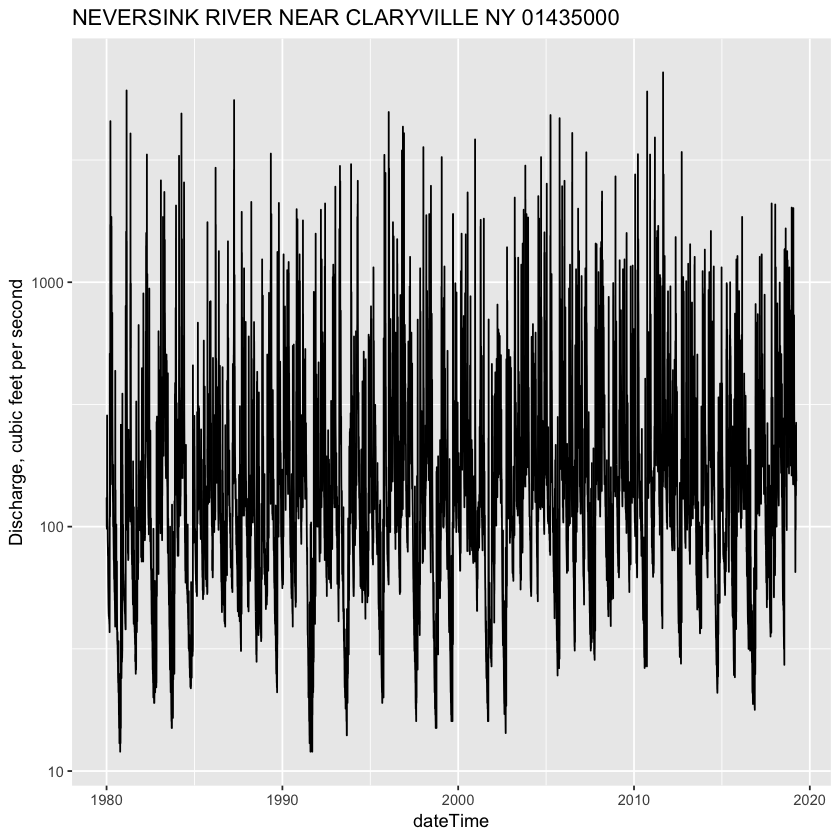

In [31]:
# y_offset = c(1000, 1000, 1000)
# x_offset = c(300, -300, 0)
titlename = paste(siteInfo$station_nm, siteInfo$site_no)
p = ggplot(df, aes(dateTime, Flow)) + geom_line() +
#         xlim(startDate, endDate)  
        ggtitle(titlename) + ylab(variableInfo$variableDescription[1]) +
            scale_y_continuous(trans='log10')
#         annotate("rect", xmin = storm_df$begin_date,
#               xmax = storm_df$end_date, ymin = min(df$Flow), ymax = max(df$Flow),  
#               fill = "red", alpha=0.5, color = "red", size = 0.5) + 
#         annotate(geom = "text", x = storm_df$begin_date + x_offset, y = max(df$Flow) + y_offset, label = storm_df$name, 
#                  color = "red")

print(p)

In [193]:
ggsave(paste0(fig_dir,titlename,"_", variableInfo$variableDescription[1],".png"), 
       width = 8, height = 5, units = "in")

## quality data

In [7]:
data <- readNWISqw(siteNumber = siteNumber, parameterCd = pCode, startDate,  endDate)

data = renameNWISColumns(data)

In [9]:
#get variable and site info
variableInfo <- attr(data, "variableInfo")
siteInfo <- attr(data, "siteInfo")

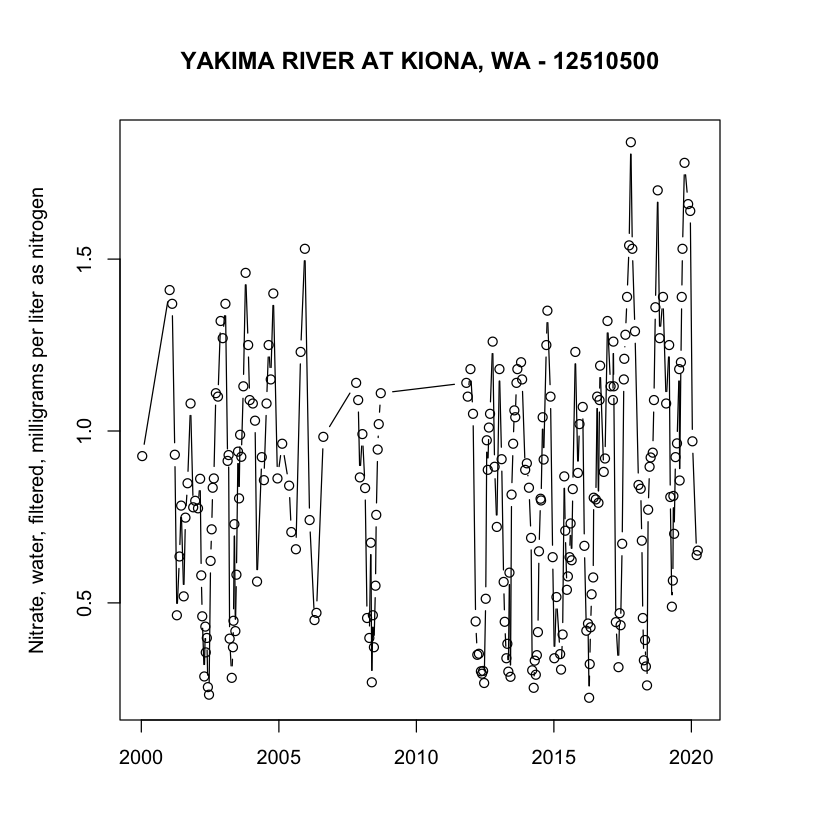

In [10]:
par(mar = c(5, 5, 5, 5))  #sets the margin (mar) size of the plot window

plot(data$sample_dt, data$result_va, type="b", ylab = variableInfo$parameter_nm, 
     xlab = "")

titlename = paste(siteInfo$station_nm, "-",siteInfo$site_no)
title(titlename)

## groundwater level

In [457]:
siteNumber = "415944074280801" #neversink

startDate <- as.Date("1980-01-01")
# endDate = as.Date('2019-01-01')
endDate = Sys.Date()

# statCd <- "00003" #00001	Maximum; 00002	Minimum ; 00003	Mean; 00008	Median

In [ ]:
data <- readNWISgwl(siteNumbers = siteNumber,  startDate = startDate,  endDate = endDate)

# data = renameNWISColumns(data)

# query data based on selected region

## use state name 

In [4]:
# pCode = c("00060", "00065")
pCode = c("00618")
# pCode <- c("00662","00665")

**Query based on state name**

In [5]:
data <- readNWISdata(stateCd="WA", parameterCd=pCode,
                     service="site", seriesCatalogOutput=TRUE)

In [8]:
write.csv(data, "./WAsites_NO3.csv")

**refine the selection**

In [6]:
sub_data = filter(data, dec_lat_va >= "46.2" & dec_lat_va <= "47.0") %>%
  filter(dec_long_va >= "-118.6" & dec_long_va <= "-120.0") %>%
  filter(parm_cd %in% pCode)
# write.csv(NO3_hanford, paste(fname, "NO3_hanford.csv"))
siteNo = unique(sub_data$site_no)

**plot in leaflet**

In [15]:
m <- leaflet(data=sub_data) %>% 
  addProviderTiles("CartoDB.Positron") %>%
  addCircleMarkers(~dec_long_va,~dec_lat_va,
                   color = "red", radius=3, stroke=FALSE,
                   fillOpacity = 0.5, opacity = 0.8,
                   popup=~station_nm)

In [ ]:
m

In [ ]:
saveWidget(m, file=paste(out_dir, "m.html", sep = ""))

## use HUC/box region

In [7]:
pCode = c("00010","00060", "00065","00095","00300","00301","00400", "00618", "00620", "00681","63680","72019","99133") # river gage parameters.

HUCcode = c("17030002") # no smaller than HUC8

### retrive sites available within HUC region

In [8]:
sites <- readNWISdata(huc = HUCcode, parameterCd = pCode, service="site", asDateTime = TRUE,
                     seriesCatalogOutput=TRUE)

In [14]:
dim(sites)

[1] 7371   24

In [9]:
sub_sites = sites %>%
        filter(parm_cd %in% pCode) %>%
        filter(medium_grp_cd %in% "wat") %>%
        filter(count_nu >= 1)   
#        filter(end_date >= as.Date('2010-01-01'))

In [16]:
unique_sites <- sub_sites[!duplicated(sub_sites[c('site_no', 'parm_cd')]),] 

In [25]:
head(unique_sites)

,agency_cd,site_no,station_nm,site_tp_cd,dec_lat_va,dec_long_va,coord_acy_cd,dec_coord_datum_cd,alt_va,alt_acy_va,⋯,stat_cd,ts_id,loc_web_ds,medium_grp_cd,parm_grp_cd,srs_id,access_cd,begin_date,end_date,count_nu
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<dbl>,<lgl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
1,USGS,12487050,"NF LITTLE NACHES RIVER AB MF NEAR CLIFFDELL, WA",ST,47.08956,-121.2323,S,NAD83,3240.,10,⋯,NA,0,NA,wat,PHY,1645597,0,1989-10-18,1990-10-23,3
2,USGS,12487050,"NF LITTLE NACHES RIVER AB MF NEAR CLIFFDELL, WA",ST,47.08956,-121.2323,S,NAD83,3240.,10,⋯,NA,0,NA,wat,PHY,1646694,0,1989-10-18,1990-10-23,3
3,USGS,12487050,"NF LITTLE NACHES RIVER AB MF NEAR CLIFFDELL, WA",ST,47.08956,-121.2323,S,NAD83,3240.,10,⋯,NA,0,NA,wat,INN,154302,0,1990-09-11,1990-09-11,1
4,USGS,12487050,"NF LITTLE NACHES RIVER AB MF NEAR CLIFFDELL, WA",ST,47.08956,-121.2323,S,NAD83,3240.,10,⋯,NA,0,NA,wat,INN,154302,0,1990-09-11,1990-09-11,1
5,USGS,12487050,"NF LITTLE NACHES RIVER AB MF NEAR CLIFFDELL, WA",ST,47.08956,-121.2323,S,NAD83,3240.,10,⋯,NA,0,NA,wat,PHY,17028275,0,1989-10-18,1989-10-18,1
6,USGS,12487050,"NF LITTLE NACHES RIVER AB MF NEAR CLIFFDELL, WA",ST,47.08956,-121.2323,S,NAD83,3240.,10,⋯,NA,0,NA,wat,NUT,197186,0,1990-10-23,1990-10-23,1


In [22]:
table(unique_sites['parm_cd'])


00010 00060 00065 00095 00300 00301 00400 00618 00620 00681 72019 
   81     9     3    85    47     5    81    14    28    15  1337 

In [17]:
dim(unique_sites)

[1] 1705   24

In [19]:
write.csv(unique_sites, paste("./data/ARW_USGS_sites.csv", sep = ""))

**select sites up to date**

In [ ]:
# sub_sites_updated = filter(sub_sites, parm_cd %in% pCode & end_date > as.Date('2010-01-01'))
# write.csv(sub_sites_updated, paste(out_dir, "EastTaylor_USGS_sites_endDate2010.csv", sep = ""))
# sub_sites_updated = filter(sub_sites, parm_cd %in% pCode & end_date > as.Date('2020-01-01'))
# write.csv(sub_sites_updated, paste(out_dir, "EastTaylor_USGS_sites_endDate2020.csv", sep = ""))
# unique_sites_parm <- sub_sites_updated[!duplicated(sub_sites_updated[c('site_no', 'parm_cd')]),] 

# unique_sites <- sub_sites_updated[!duplicated(sub_sites_updated[c('site_no')]),] 

**plot in leaflet**

In [28]:
m <- leaflet(data=sub_sites) %>% 
  addProviderTiles("CartoDB.Positron") %>%
  addCircleMarkers(~dec_long_va,~dec_lat_va,
                   color = "green", radius=3, stroke=FALSE,
                   fillOpacity = 0.5, opacity = 0.8,
                   popup=~site_no)

m

HTML widgets cannot be represented in plain text (need html)

In [ ]:
# saveWidget(m, file=paste(out_dir, "USGS_sites_updated.html", sep = ""))

### retrive data within box region

In [134]:
pCode = '99133'
statCode = '00001'
start.Date <- "2019-02-01"
end.Date <- "2019-03-01"

In [135]:
## use long_lat box to query data from sites
data <- readNWISdata(bBox = box.region, parameterCd = pCode, statCd = statCode, service="qw", 
                     startDate = start.Date, endDate = end.Date , asDateTime = TRUE)

Downloading: 32 kB      

limit_output extension: Maximum message size of 10000 exceeded with 10018 characters

In [136]:
data = renameNWISColumns(data)

In [19]:
## use long_lat box to query data from database
qwData_data <- readNWISdata(bBox=box.region, parameterCd = pCode, qw_attributes="expanded", service="qw")
# qwData_data_NO3 = filter(qwData_data, parm_cd %in% pCode)

In [ ]:
df = data.frame(qwData_data$agency_cd, qwData_data$site_no, qwData_data$startDateTime, 
                             qwData_data$sample_start_time_datum_cd, qwData_data$p00010)
names(df) = c("agency","site_no", "DateTime", "tz", "temperature_C" )

In [ ]:
write.csv(df, paste( "./data/USGS_temp_data.csv", sep = ""))

## retrieve variables

### GW

In [29]:
pCode = "72019"
sub_sites = filter(unique_sites, dec_lat_va >= "46.80" & dec_lat_va <= "47.0") %>%
  filter(dec_long_va >= "-121.1" & dec_long_va <= "-121.6") %>%
  filter(parm_cd %in% pCode)

siteNo = unique(sub_sites$site_no)

In [72]:
siteInfo =sub_sites %>% select(site_no, station_nm, dec_lat_va, dec_long_va, alt_va, alt_datum_cd)

In [63]:
# siteNumber = "465144121174901" 

startDate <- as.Date("1900-01-01")
endDate = Sys.Date()
# statCd <- "00003" #00001	Maximum; 00002	Minimum ; 00003	Mean; 00008	Median

In [65]:
data <- readNWISgwl(siteNumbers = siteNo, startDate = startDate, endDate = endDate)

In [73]:
dataSummary <- data %>% left_join(siteInfo, by = "site_no")

In [76]:
m <- leaflet(data=dataSummary) %>% 
  addProviderTiles("CartoDB.Positron") %>%
  addCircleMarkers(~dec_long_va,~dec_lat_va,
                   color = "green", radius=3, stroke=FALSE,
                   fillOpacity = 0.5, opacity = 0.8,
                   popup=~site_no)

m

HTML widgets cannot be represented in plain text (need html)

In [75]:
write.csv(dataSummary, paste( "./data/ARW_gw_data.csv", sep = ""))

# retrieve data from Water Quality Portal

## output columns

Some key data columns are listed:

Column|Description|Example
---|---|---
OrganizationIdentifier|Data source|USGS-NJ
OrganizationFormalName|Data source|USGS New Jersey Water Science Center
MonitoringLocationIdentifier|location of the site|"USGS-01378690"
ActivityMediaName|media type|eg. water
ActivityStartDate|start date|eg. 2015-01-06
ActivityStartTime.Time|time of the day|eg. 10:00:00
ActivityEndDate|end date|eg. 2015-01-06
ActivityEndTime.Time|time of the day|eg. 10:00:00
CharacteristicName|chemical species|Nitrate
ResultSampleFractionText|specie type|e.g. Dissovled, Total, Unfilter
ResultMeasureValue|concentration|
ResultMeasure.MeasureUnitCode|unit|eg. mg/L
ProviderName|agency provider|eg. STORET

Some key attribute columns are listed: 

use function `attr(df, 'siteInfo')`

Column|Description|Example
---|---|---
site_no|site number|USGS-01378690
dec_lat_va|latitude|
dec_lon_va|longitude
hucCd|huc unit code|02030103
HUCEightDigitCode|"02030103"
LatitudeMeasure|latitude|
LongitudeMeasure|longitude|





## query based on region

### query nutrients

In [36]:
media = "Water"
name = "Nitrate" #"Organic carbon", "Nitrate", "Phosphorus", "Nitrogen", "Calcium"
sampleFraction = "Dissolved"
unit = "mg/L"

# parameterCd = "USGS-00600"
startDate <- as.Date("2000-01-01")
# endDate = as.Date('2019-01-01')
endDate = Sys.Date()
# startDate = Sys.Date() - 365*10 # past 10 years
box.region = c(-76.6,38.3,-74.0,42.6) #delaware river basin
# HUCode = c("02040201","02040202", "02040203", "02040204","02040205", 
#             "02040206", "02040207", "02040101","02040102", "02040103", 
#             "02040104","02040105", "02040106") # DRB
HUCode = c("1701", "1702", "1703", "1704", "1705", "1706", "1707", "1708", "1709") # CRB
countrycode = "US"
statecode = "WA"

query data, possible arguments: `characteristicName`, `characteristicType`, `parameterCd`,`bBox`, `siteid`,`statecode`,`countycode`,`providers`,`querySummary`(return # of unique sites). See [full list](https://www.waterqualitydata.us/webservices_documentation/#WQPWebServicesGuide-Submitting)

search for country

In [75]:
qwData <- readWQPdata(countrycode = countrycode, characteristicName=name, sampleMedia = media, startDate = startDate, 
                      endDate = endDate)

write.csv(qwData, file = paste0(out_dir, sampleFraction, " ", name,"_data_US.csv"))

search for HUC code

In [38]:
qwData <- readWQPdata(huc=HUCode, characteristicName=name, sampleMedia = media, startDate = startDate, 
                      endDate = endDate)

write.csv(qwData, file = paste0(out_dir, sampleFraction, " ", name,"_CRB_00_20.csv"))

**search based on state code**

In [12]:
qwData <- readWQPdata(statecode = statecode, characteristicName=name, sampleMedia = media, startDate = startDate, 
                      endDate = endDate)

write.csv(qwData, file = "./nitrate_WA.csv")

**get attributes of sites**

In [39]:
varInfo = attr(qwData, "variableInfo")
siteInfo <- attr(qwData, "siteInfo")

# dim(siteInfo)

**convert `ug/l` to `mg/l`**

In [40]:
table(qwData$ResultMeasure.MeasureUnitCode)
table(qwData$ResultSampleFractionText)


      mg/l  mg/l as N mg/l asNO3        ppm      ueq/L       ug/l 
      9940      14876      13952        397        238       1002 


    Dissolved Filtered, lab          None         Total    Unfiltered 
        36611           158           468          5443            97 

In [41]:
qwData = qwData %>% mutate(ResultMeasureValue = 
                           ifelse(grepl("ug/l", qwData$ResultMeasure.MeasureUnitCode, ignore.case = T), 
                                                       ResultMeasureValue/1000, ResultMeasureValue))

In [451]:
# qwSummary = read.csv(paste0(out_dir, sampleFraction, " ",name,"_site_summary_80_19.csv"), stringsAsFactors=FALSE)

In [43]:
qwSummary <- qwData %>%
  filter(!is.na(ResultMeasureValue) & !is.na(ActivityStartDateTime)) %>%
  filter(ResultSampleFractionText %in% sampleFraction) %>%
  group_by(MonitoringLocationIdentifier) %>%
  summarise(count=n(),
            start=min(ActivityStartDateTime, na.rm = TRUE),
            end=max(ActivityStartDateTime, na.rm = TRUE),
            max = max(ResultMeasureValue, na.rm = TRUE),
           mean = mean(ResultMeasureValue, na.rm = TRUE),
            median = median(ResultMeasureValue, na.rm = TRUE),
           min = min(ResultMeasureValue, na.rm = TRUE)) %>%
  filter(count >= 1) %>%
  arrange(-count) %>%
  left_join(siteInfo, by = "MonitoringLocationIdentifier")

write.csv(qwSummary, file = paste0(out_dir, "./nitrate_site_summary_CRB_00_20.csv"))

**plot on the map**

classify whether type is groundwater or surface water

In [44]:
qwSummary = mutate(qwSummary, type = ifelse(grepl("Well", qwSummary$MonitoringLocationTypeName, ignore.case = T),"gw", "sw"))

add cumstom legend

In [51]:
# colors <- c("red", "white", "blue", "white", "blue", "red")
#         labels <- c("filled_square", "empty_square", "big_square", "empty_circle", "filled_circle", "big_circle")
#         sizes <- c(10, 20, 30, 10, 20, 30)
#         shapes <- c("square", "square", "square", "circle", "circle", "circle")
#         borders <- c("red", "blue", "black", "blue", "blue", "black")

addLegendCustom <- function(map, colors, labels, sizes, shapes, borders, opacity = 0.8){

            make_shapes <- function(colors, sizes, borders, shapes) {
                shapes <- gsub("circle", "50%", shapes)
                shapes <- gsub("square", "0%", shapes)
                paste0(colors, "; width:", sizes, "px; height:", sizes, "px; border:3px solid ", borders, "; border-radius:", shapes)
            }
            make_labels <- function(sizes, labels) {
                paste0("<div style='display: inline-block;height: ", 
                       sizes, "px;margin-top: 4px;line-height: ", 
                       sizes, "px;'>", labels, "</div>")
            }

            legend_colors <- make_shapes(colors, sizes, borders, shapes)
            legend_labels <- make_labels(sizes, labels)

            return(addLegend(map, colors = legend_colors, labels = legend_labels, opacity = opacity, title = "Site Type"))
        }

In [57]:
colors <- c("white", "darkblue")
        labels <- c("well", "stream/river")
        sizes <- c(10, 10)
        shapes <- c("circle", "circle")
        borders <- c("darkblue","darkblue")

col_types <- c("darkblue","dodgerblue","green4","gold1","orange","brown","red")
leg_vals <- unique(as.numeric(quantile(qwSummary$max, 
                probs=c(0,0.01,0.1,0.25,0.5,0.75,0.9,.99,1), na.rm=TRUE)))
pal = colorBin(col_types, qwSummary$max, bins = leg_vals)
rad <- 3*seq(1,4,length.out = 16)
qwSummary$sizes <- rad[as.numeric(cut(qwSummary$count, breaks=16))]
          
m = leaflet(data=qwSummary) %>% 
  setView(lng = -120, lat = 46, zoom = 7) %>%
  addProviderTiles("CartoDB.Positron") %>%
#   addPolygons(data=delawareGap, weight=2, col= 'green') %>%
#   addPolygons(data=neversink, weight=2, col= 'green') %>%
#   addPolygons(data=frenchCreek, weight=2, col= 'green') %>%
#   addPolygons(data=delaware_river, weight=2, col= 'blue') %>%
#   addPolylines(data=delaware_river_trib, weight=1, col= 'gray') %>%
#   addPolylines(data=DRB_bound, weight=2, col= 'black') %>%
#   addPolylines(data=CRB_HU4, weight=1, col= 'gray') %>%
#   addPolylines(data=CRB_bound, weight=2, col= 'black') %>%
  addCircleMarkers(~dec_lon_va,~dec_lat_va,
                   fillColor = ~pal(max),radius = ~sizes,fillOpacity = ~ifelse(type == "gw", 0, 0.8), 
                   stroke=T, opacity = 1,color = ~pal(max), weight = 1,
                   popup= paste("station:", qwSummary$station_nm, "<br>",
                                "id:", qwSummary$site_no, "<br>",
                                "type:", qwSummary$MonitoringLocationTypeName, "<br>",
                               "count:", qwSummary$count,  "<br>",
                               "maximum:", qwSummary$max,  "<br>",
                                "median:", qwSummary$median, "<br>",
                                "mean:", qwSummary$mean,  "<br>",
                                "minimum:", qwSummary$min
                               )) %>%
  addLegend(position = 'bottomleft',
            pal=pal,
            values=~max,
            opacity = 0.8,
            labFormat = labelFormat(digits = 1), 
            title = paste0('Max Value (2000~present) <br>', '(', sampleFraction, ' ', name, '-', unit, ')' )) %>%
  addLegendCustom(colors, labels, sizes, shapes, borders)

In [ ]:
m

In [ ]:
saveWidget(m, file=paste(out_dir, sampleFraction, " ", name,"_CRB_map.html", sep = ""))
mapshot(m, file = paste(out_dir, sampleFraction, " ", name,"_CRB_map.png", sep = ""))

### query water isotope

In [3]:
media = "Water"
group = "Stable Isotopes"
name = c("Oxygen Delta 18", "Deuterium/Hydrogen ratio")
# name = "Oxygen Delta 18"
sampleFraction = "Dissolved"
unit = "per mil"

# parameterCd = "USGS-00600"
startDate <- as.Date("1980-01-01")
# endDate = as.Date('2019-01-01')
endDate = Sys.Date()
# startDate = Sys.Date() - 365*10 # past 10 years
box.region = c(-76.6,38.3,-74.0,42.6) #delaware river basin
HUCcode = c("02040201","02040202", "02040203", "02040204","02040205", 
            "02040206", "02040207", "02040101","02040102", "02040103", 
            "02040104","02040105", "02040106") # DRB
# HUCcode = c("020402*", "020401*")
countrycode = "US"

In [ ]:
qwData <- readWQPdata(huc=HUCcode, chracteristicType = group, characteristicName=name, sampleMedia = media, startDate = startDate, 
                      endDate = endDate)

In [350]:
write.csv(qwData, file = paste0(out_dir, group, " ", name,"_data_80_19.csv"))

### query temperature

In [5]:
media = "Water"
name = "Temperature, water" #"Organic carbon", "Nitrate", "Phosphorus", "Nitrogen", "Calcium"
# sampleFraction = "Dissolved"
unit = "deg C"

# parameterCd = "USGS-00600"
startDate <- as.Date("1980-01-01")
# endDate = as.Date('2019-01-01')
endDate = Sys.Date()
# startDate = Sys.Date() - 365*10 # past 10 years
box.region = c(-76.6,38.3,-74.0,42.6) #delaware river basin
HUCcode = c("02040201","02040202", "02040203", "02040204","02040205", 
            "02040206", "02040207", "02040101","02040102", "02040103", 
            "02040104","02040105", "02040106") # DRB
countrycode = "US"

query data, possible arguments: `characteristicName`, `characteristicType`, `parameterCd`,`bBox`, `siteid`,`statecode`,`countycode`,`providers`,`querySummary`(return # of unique sites). See [full list](https://www.waterqualitydata.us/webservices_documentation/#WQPWebServicesGuide-Submitting)

search for country

In [460]:
# qwData <- readWQPdata(countrycode = countrycode, characteristicName=name, sampleMedia = media, startDate = startDate, 
#                       endDate = endDate)

# write.csv(qwData, file = paste0(out_dir, sampleFraction, " ", name,"_data_US.csv"))

search for HUC code

In [6]:
qwData <- readWQPdata(huc=HUCcode, characteristicName=name, startDate = startDate, 
                      endDate = endDate)

write.csv(qwData, file = paste0(out_dir, name,"_data_80_19.csv"))

**get attributes of sites**

In [7]:
varInfo = attr(qwData, "variableInfo")
siteInfo <- attr(qwData, "siteInfo")

# dim(siteInfo)

**convert `deg F` to `deg C`**

In [8]:
table(qwData$ResultMeasure.MeasureUnitCode)
table(qwData$ResultSampleFractionText)


     deg C deg C           deg F deg F      
    179313       8513        794        736 


     Total Unfiltered 
       516        238 

In [9]:
qwData = qwData %>% mutate(ResultMeasureValue = 
                           ifelse(grepl("F", qwData$ResultMeasure.MeasureUnitCode, ignore.case = T), 
                                                       (ResultMeasureValue - 32)*5/9, ResultMeasureValue))

In [451]:
# qwSummary = read.csv(paste0(out_dir, sampleFraction, " ",name,"_site_summary_80_19.csv"), stringsAsFactors=FALSE)

In [32]:
qwSummary <- qwData %>%
  filter(!is.na(ResultMeasureValue) & !is.na(ActivityStartDateTime)) %>%
  group_by(MonitoringLocationIdentifier) %>%
  summarise(count=n(),
            start=min(ActivityStartDateTime, na.rm = TRUE),
            end=max(ActivityStartDateTime, na.rm = TRUE),
            max = max(ResultMeasureValue, na.rm = TRUE),
           mean = mean(ResultMeasureValue, na.rm = TRUE),
            median = median(ResultMeasureValue, na.rm = TRUE),
           min = min(ResultMeasureValue, na.rm = TRUE)) %>%
  filter(count >= 1) %>%
  arrange(-count) %>%
  left_join(siteInfo, by = "MonitoringLocationIdentifier")

write.csv(qwSummary, file = paste0(out_dir, name,"_site_summary_80_19.csv"))

**plot on the map**

classify whether type is groundwater or surface water

In [34]:
qwSummary = mutate(qwSummary, type = ifelse(grepl("Well", qwSummary$MonitoringLocationTypeName, ignore.case = T),"gw", "sw"))

In [37]:
colors <- c("white", "darkblue")
        labels <- c("well", "stream/river")
        sizes <- c(10, 10)
        shapes <- c("circle", "circle")
        borders <- c("darkblue","darkblue")

col_types <- c("darkblue","dodgerblue","green4","gold1","orange","brown","red")
leg_vals <- unique(as.numeric(quantile(qwSummary$max, 
                probs=c(0,0.01,0.1,0.25,0.5,0.75,0.9,.99,1), na.rm=TRUE)))
pal = colorBin(col_types, qwSummary$max, bins = leg_vals)
rad <- 3*seq(1,4,length.out = 16)
qwSummary$sizes <- rad[as.numeric(cut(qwSummary$count, breaks=16))]
          
m = leaflet(data=qwSummary) %>% 
  setView(lng = -75.1, lat = 40.8, zoom = 7) %>%
  addProviderTiles("CartoDB.Positron") %>%
#   addPolygons(data=delawareGap, weight=2, col= 'green') %>%
#   addPolygons(data=neversink, weight=2, col= 'green') %>%
#   addPolygons(data=frenchCreek, weight=2, col= 'green') %>%
#   addPolygons(data=delaware_river, weight=2, col= 'blue') %>%
#   addPolylines(data=delaware_river_trib, weight=1, col= 'gray') %>%
#   addPolylines(data=DRB_bound, weight=2, col= 'black') %>%
  addCircleMarkers(~dec_lon_va,~dec_lat_va,
                   fillColor = ~pal(max),radius = ~sizes,fillOpacity = ~ifelse(type == "gw", 0, 0.8), 
                   stroke=T, opacity = 1,color = ~pal(max), weight = 1,
                   popup= paste("station:", qwSummary$station_nm, "<br>",
                                "id:", qwSummary$site_no, "<br>",
                                "type:", qwSummary$MonitoringLocationTypeName, "<br>",
                                "start date:", qwSummary$start,  "<br>",
                                "end date:", qwSummary$end,  "<br>",
                               "count:", qwSummary$count,  "<br>",
                               "maximum:", qwSummary$max,  "<br>",
                                "mean:", qwSummary$mean,  "<br>",
                                "median:", qwSummary$median,  "<br>",
                                "minimum:", qwSummary$min
                               )) %>%
  addLegend(position = 'bottomleft',
            pal=pal,
            values=~max,
            opacity = 0.8,
            labFormat = labelFormat(digits = 1), 
            title = paste0('Max Value (1980~present) <br>', '(', name, '-', unit, ')' )) %>%
  addLegendCustom(colors, labels, sizes, shapes, borders)

In [ ]:
m

In [39]:
saveWidget(m, file=paste(fig_dir,  name,"_map.html", sep = ""))
mapshot(m, file = paste(fig_dir,  name,"_map.png", sep = ""))

**plot single site**

In [28]:
site_id = "31DELRBC-091017"
siteData = qwData[qwData$MonitoringLocationIdentifier == site_id, ]

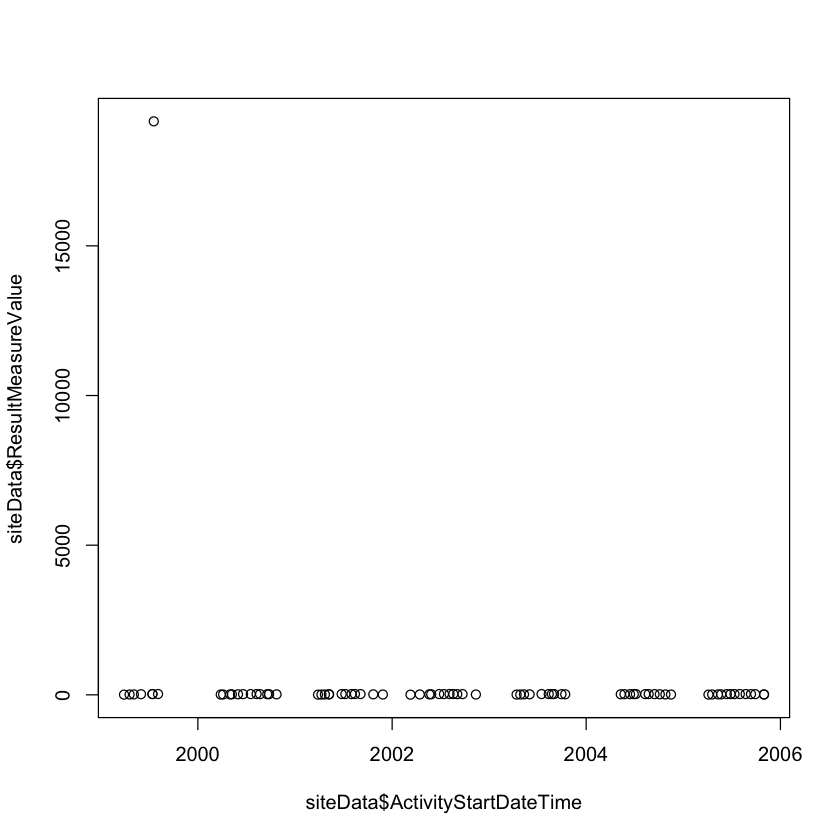

In [31]:
plot(siteData$ActivityStartDateTime, siteData$ResultMeasureValue) 

## query based on single site

In [17]:
media = "Water"
group = "Stable Isotopes"
# name = "Organic carbon"
name = "Nitrate"
sampleFraction = "Dissolved"
unit = "mg/L"

# siteID = c("USGS-01434025", "USGS-01434021", "USGS-0143400680")
# siteID = c("USGS-12510500")
siteID = c("USGS-12505450")

# parameterCd = "00600"
# paraCd = c("00060", "00065")
# paraCd = "00681" #DOC
paraCd = "00618"
startDate <- as.Date("2000-01-01")
# endDate = as.Date('2019-01-01')
endDate = Sys.Date()

In [18]:
qwData = readWQPqw(siteNumbers = siteID, parameterCd = paraCd, startDate = startDate, endDate = endDate)

In [21]:
write.csv(qwData, file = "./USGS-12505450_NO3.csv")

In [18]:
start.time = as.Date('2005-01-01')
end.time = as.Date('2006-01-01')

In [ ]:
qwData.copy = filter(qwData, as.numeric(substr(ActivityStartDateTime,1,4)) ==2005)

In [ ]:
qwData <- readWQPdata(siteid = siteID, characteristicName=name, sampleMedia = media, startDate = startDate, 
                      endDate = endDate)